In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
AUTOTUNE = tf.data.experimental.AUTOTUNE 

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = [64,64]
batch_size = 64
epoch = 100

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train/',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    color_mode='grayscale',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [7]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train',
        labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    color_mode='grayscale',
    seed=123,
    image_size=(64,64),
    batch_size=batch_size,
)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [8]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_data.class_names = class_names
val_data.class_names = class_names

NUM_CLASSES = len(class_names)

TypeError: only integer scalar arrays can be converted to a scalar index

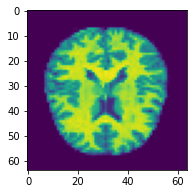

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_data = train_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [10]:
# train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
#         tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 1)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [12]:
model = build_model()

METRICS = [
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [13]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

checkpoint_filepath = 'src/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[early_stopping_cb, lr_scheduler, model_checkpoint_callback],
    epochs=epoch)

Epoch 1/100
64/65 [============================>.] - ETA: 0s - loss: 1.2066 - AUC: 0.7487 - precision: 0.5198 - recall: 0.3013WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: src/checkpoint/assets
65/65 [==============================] - 17s 255ms/step - loss: 1.2069 - AUC: 0.7486 - precision: 0.5196 - recall: 0.3012 - val_loss: 5.1997 - val_AUC: 0.6838 - val_precision: 0.4932 - val_recall: 0.4932
Epoch 2/100
65/65 [==============================] - 14s 212ms/step - loss: 0.9672 - AUC: 0.8112 - precision: 0.6716 - recall: 0.3000 - val_l

Epoch 22/100
65/65 [==============================] - 14s 210ms/step - loss: 0.8024 - AUC: 0.8718 - precision: 0.7163 - recall: 0.4196 - val_loss: 2.4289 - val_AUC: 0.7699 - val_precision: 0.5114 - val_recall: 0.5059
Epoch 23/100
65/65 [==============================] - 13s 207ms/step - loss: 0.7844 - AUC: 0.8788 - precision: 0.7274 - recall: 0.4337 - val_loss: 0.9059 - val_AUC: 0.8592 - val_precision: 0.6012 - val_recall: 0.4961


In [14]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [15]:
!pip install pydot

/usr/bin/sh: 1: pip: not found


In [18]:
!brew install graphviz

/bin/sh: 1: brew: not found


In [26]:
#data augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)



In [15]:

datagen = ImageDataGenerator(validation_split=0.2, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)
train_generator = datagen.flow_from_directory(
        'Alz_data/train',
        target_size=(64,64),
        batch_size=100,
        color_mode='grayscale',
        class_mode='categorical',
        subset='training')
validation_generator = datagen.flow_from_directory(
        'Alz_data/train',
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=100,
        class_mode='categorical',
        subset='validation')



Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [16]:
img_hist = model.fit(
        train_generator,
        validation_data=validation_generator,
        callbacks=[early_stopping_cb, lr_scheduler, model_checkpoint_callback], 
        epochs=epoch)

Epoch 1/100
41/41 [==============================] - 9s 230ms/step - loss: 0.9574 - AUC: 0.8181 - precision: 0.6927 - recall: 0.2745 - val_loss: 40.2135 - val_AUC: 0.6670 - val_precision: 0.5005 - val_recall: 0.5005
Epoch 2/100
41/41 [==============================] - 9s 222ms/step - loss: 0.9239 - AUC: 0.8306 - precision: 0.7098 - recall: 0.2955 - val_loss: 0.9773 - val_AUC: 0.8039 - val_precision: 0.6366 - val_recall: 0.2551
Epoch 3/100
41/41 [==============================] - 9s 220ms/step - loss: 0.9013 - AUC: 0.8400 - precision: 0.7247 - recall: 0.3302 - val_loss: 9.8598 - val_AUC: 0.6699 - val_precision: 0.5005 - val_recall: 0.5005
Epoch 4/100
41/41 [==============================] - 9s 217ms/step - loss: 0.8968 - AUC: 0.8403 - precision: 0.7163 - recall: 0.3241 - val_loss: 1.5464 - val_AUC: 0.5758 - val_precision: 0.3082 - val_recall: 0.0958
Epoch 5/100
41/41 [==============================] - 9s 221ms/step - loss: 0.8934 - AUC: 0.8430 - precision: 0.6979 - recall: 0.3472 - val_

In [17]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/test/',
            labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

Found 1279 files belonging to 4 classes.


In [12]:
test_data = test_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

NameError: name 'one_hot_label' is not defined

In [18]:
score = model.evaluate(test_data)

20/20 [==============================] - 1s 48ms/step - loss: 1.0854 - AUC: 0.8248 - precision: 0.5972 - recall: 0.3941
